<h1>Marking ice resurfacing</h1>
Ice resurfacing on ice rinks involves the process of creating and maintaining a smooth and high-quality ice surface for skating, hockey, and other ice sports. This process includes several key stages:

1. **Base Preparation**:
   - Initially, a thin layer of water is applied to the concrete base, which freezes to create the first layer of ice.

2. **Multi-layer Application**:
   - Ice is built up in several layers to achieve the required thickness and strength. Each new layer is added after the previous one has completely frozen.

3. **Use of Special Equipment**:
   - Special machines, such as Zamboni ice resurfacers, are used to evenly distribute water and create a smooth surface. These machines are equipped with water tanks, brushes, and blades to shave off uneven ice.

4. **Ice Maintenance**:
   - Throughout the arena’s usage period, the ice is regularly treated to maintain its condition. This includes shaving off rough spots, applying water to restore the surface, and maintaining optimal ice temperature.

5. **Temperature Control**:
   - It’s important to maintain the correct ice temperature, typically around -2°C for figure skating and -7°C for hockey. The arena's air temperature is also controlled to prevent condensation and preserve ice quality.

These procedures ensure a smooth, even, and safe ice surface suitable for competitions and recreational skating.

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import datetime as dt

sns.set_theme()

In [32]:
df = pd.read_csv('../data/small_data.csv', usecols=['time', 'temp_ice'])
df['time'] = pd.to_datetime(df['time'])
df.head()

,time,temp_ice
0,2022-09-25 22:42:00,-2.322947
1,2022-09-25 22:43:00,-2.239596
2,2022-09-25 22:44:00,-2.221429
3,2022-09-25 22:45:00,-2.319333
4,2022-09-25 22:46:00,-2.386154


In [ ]:
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, vertical_spacing=0.02)
fig.add_trace(go.Scatter(x=df['time'], y=df['temp_ice'], name='Температура льда'), row=1, col=1)
fig.update_layout(margin=dict(l=10, r=10, t=30, b=10),
                  legend=dict(orientation='h', yanchor='bottom', x=0, y=1.01),
                #   width=1000,
                #   height=800,
                #   font_color="#837A4F",
                #   title_font_color="#837A4F"
                )
fig.update_traces(hoverinfo='all', hovertemplate='Дата и время: %{x}<br>Температура: %{y:.2f}°C', row=1, col=1)
fig.update_yaxes(title_text='°C', row=1, col=1)

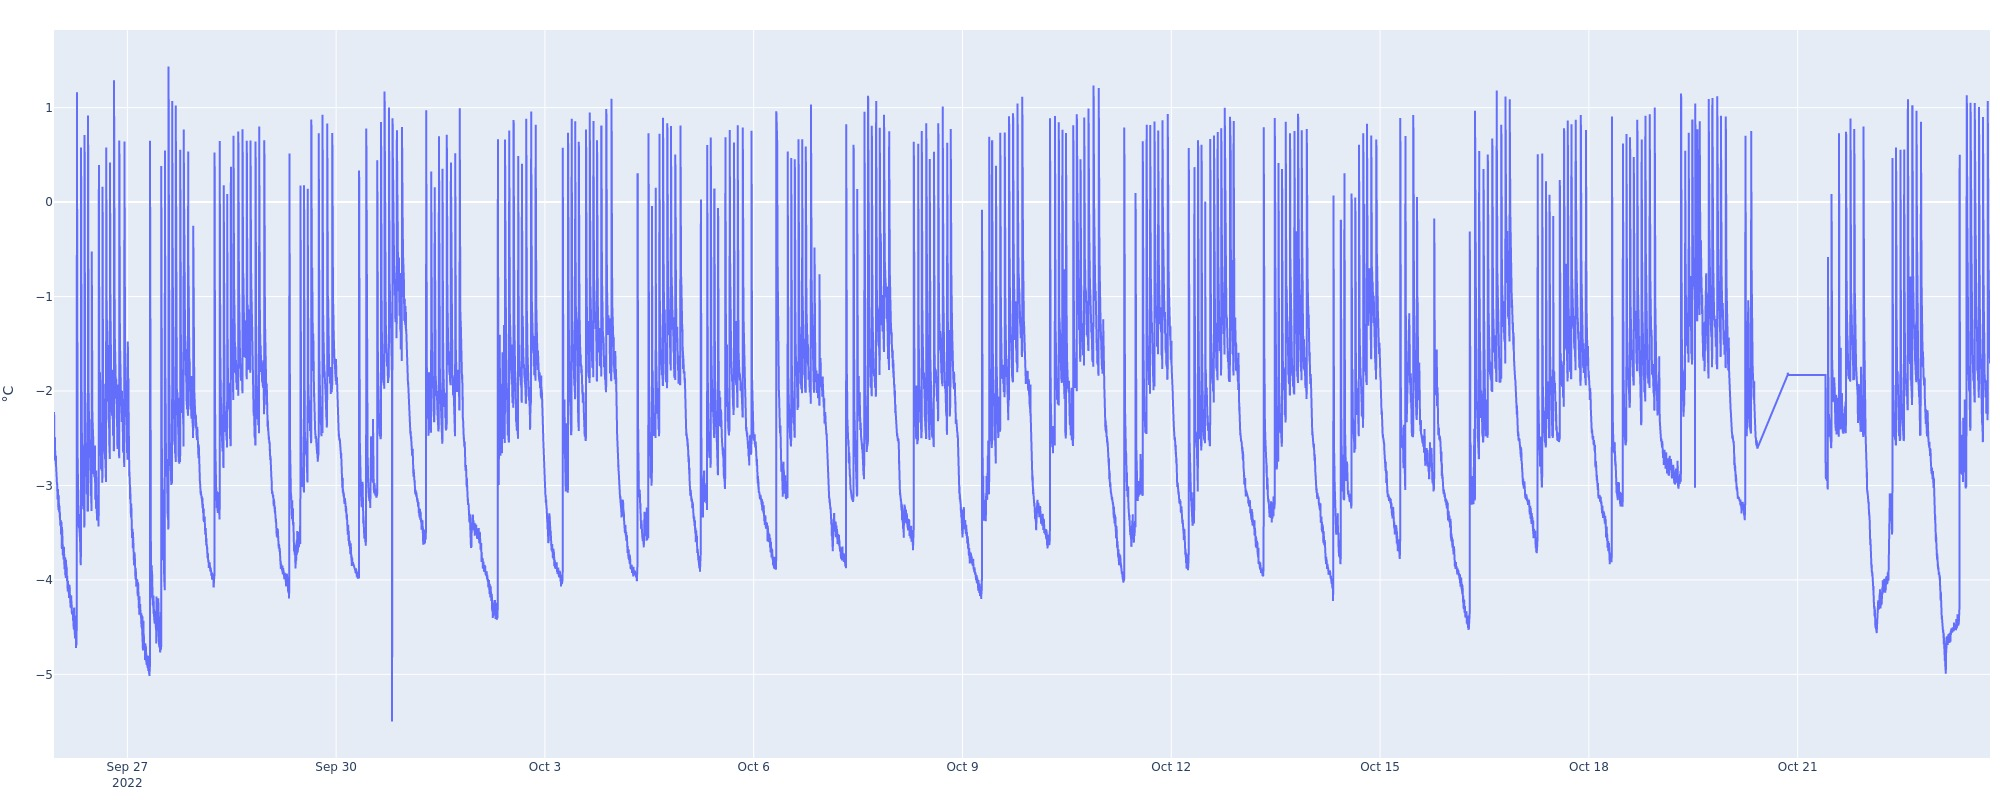

In [34]:
fig.show('jpg', width=2000, height=800)

In [35]:
df = (df
 # Обработка аномальных значений
 .assign(temp_ice=lambda df: np.where(df['temp_ice'].between(-10, 3), df['temp_ice'], np.NaN))
 .assign(temp_ice=lambda df: df['temp_ice'].ffill())
 # Дифференцируем, экспоненциально сглаженный, ряд для нахождения заливки
 .assign(diff=lambda df: df['temp_ice'].ewm(span=60).mean().diff())
 .assign(flood=lambda df: np.where(df['diff'] > 0.03, 1, 0))
 # Создаем признак, чтобы подсчитать время между заливками
 .assign(diff_time=dt.timedelta(minutes=30))
 )

# Подсчет правильного количества заливок
df.loc[df['flood'] == 1, 'diff_time'] = df.loc[df['flood'] == 1, 'time'].diff().fillna(dt.timedelta(minutes=30))
df.loc[df['diff_time'] < dt.timedelta(minutes=30), 'flood'] = 0

In [ ]:
sample_df = df[:10000]
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.02)
fig.add_trace(go.Scatter(x=sample_df['time'], y=sample_df['temp_ice'], name='Температура льда'), row=1, col=1)
fig.add_trace(go.Scatter(x=sample_df['time'], y=sample_df['flood'], name='Заливка'), row=2, col=1)
fig.update_layout(margin=dict(l=10, r=10, t=30, b=10),
                  legend=dict(orientation='h', yanchor='bottom', x=0, y=1.01),
                #   width=1000,
                #   height=800,
                #   font_color="#837A4F",
                #   title_font_color="#837A4F"
                )
fig.update_traces(hoverinfo='all', hovertemplate='Дата и время: %{x}<br>Температура: %{y:.2f}°C', row=1, col=1)
fig.update_yaxes(title_text='°C', row=1, col=1)

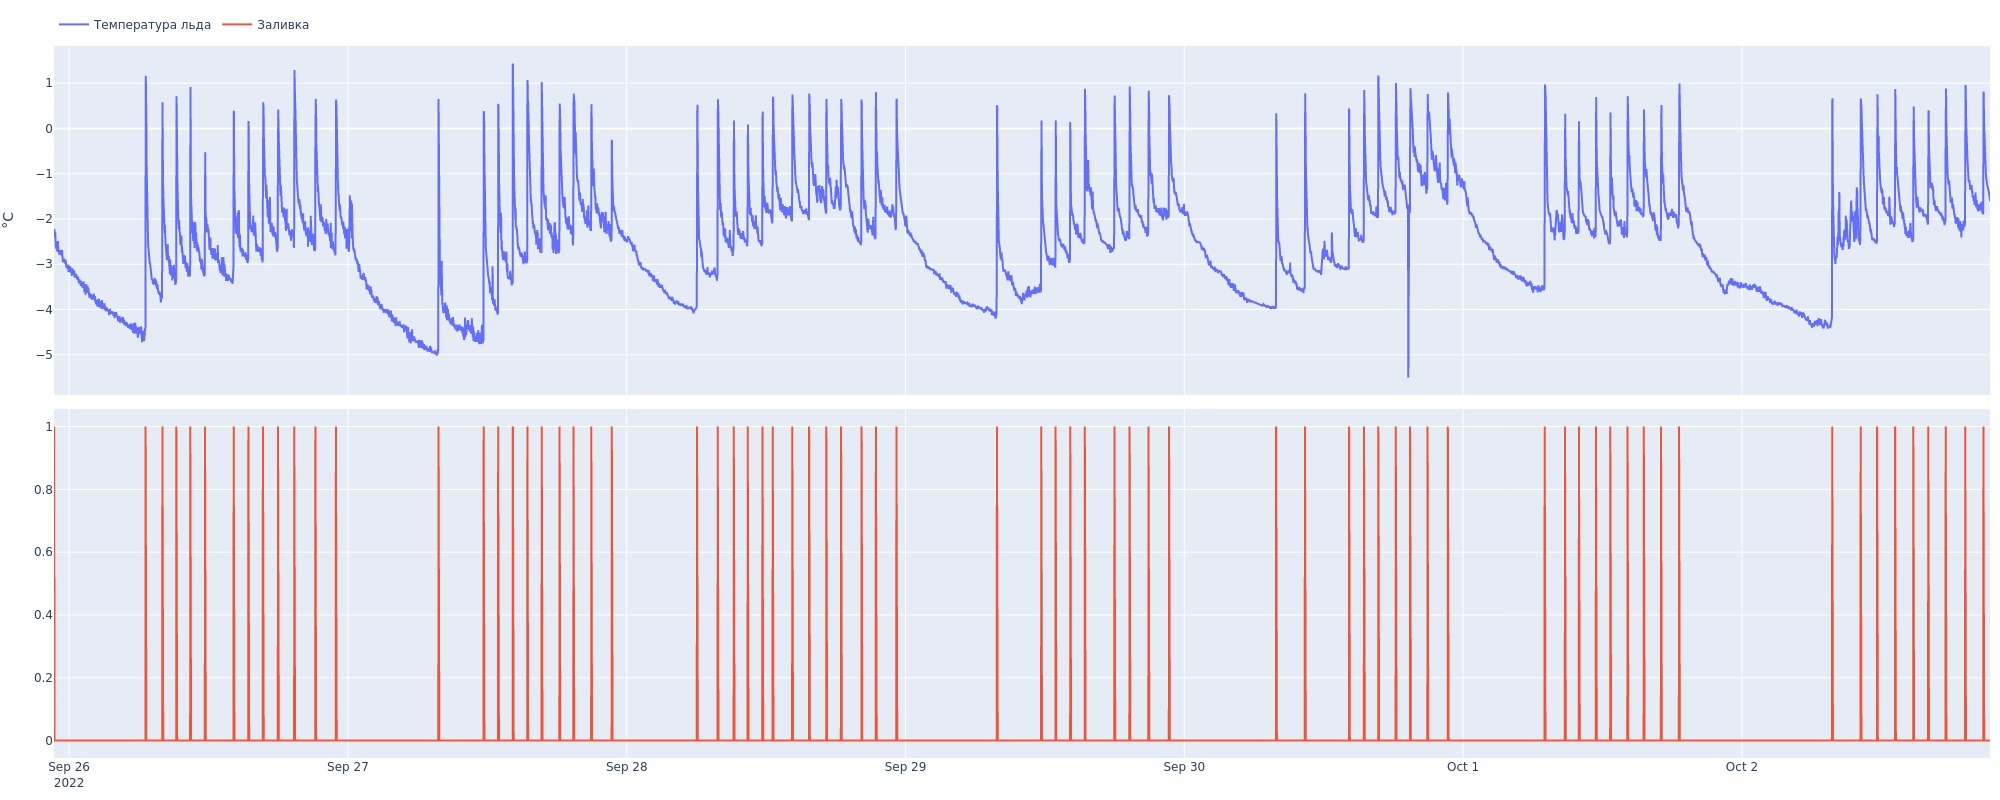

In [38]:
fig.show('jpg', width=2000, height=800)

In [44]:
df[['time', 'temp_ice', 'flood']].to_csv('../data/resurfacing_marking_data.csv', index=False)